In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finance_byu.summarize import summary
import statsmodels.formula.api as smf
import yfinance as yf

In [62]:
df = pd.read_parquet("~/Data/BOQ_data.parquet")

df.tail()

,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,s2invt,s2rect,sale,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv
3568650,0.211263,0.114912,-0.746238,0.861151,-12.189408,2023-08-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000152,0.708916,2.250092e+07,-1.580970
3568651,0.211263,0.114912,-0.750723,0.865635,-11.613183,2023-09-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000133,0.465122,1.476294e+07,-0.371920
3568652,0.211263,0.114912,-0.731231,0.846143,-12.752123,2023-10-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000177,0.531342,1.686876e+07,0.809301
3568653,0.211263,0.114912,-0.731231,0.846143,-7.943286,2023-11-30,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000245,0.614813,1.954419e+07,0.278301
3568654,0.211263,0.114912,-0.731231,0.846143,-9.359996,2023-12-31,3.897415e+08,3164000.0,0.0,0.0,...,6.344887,26.084534,81462.0,579615.973,0.513517,0.086187,0.000186,0.599491,1.905735e+07,0.967711


In [63]:
# Create initial dataframe. Keep only necessary columns, and generate date variables

keep = ['DATE', 'PERMNO', 'BEME', 'E2P', 'sale', 'ME', 'PRC', 'RET', ]

df = df[keep]

df = df.rename(columns={'DATE':'caldt','PERMNO':'permno','BEME':'beme', 'E2P': 'ep', 'sale': 'sales', 'ME': 'me', 'PRC':'prc', 'RET': 'ret'})

df = df.sort_values(['permno','caldt'])

df['mdt'] = df['caldt'].dt.strftime("%Y-%m")
df['month'] = df['caldt'].dt.strftime("%m")

# In sample period
start = '1963-04-01'
end = '1990-04-30'

# Out of sample period
# start = '1990-04-30'
# end = '2024-10-07'

df = df[df['caldt'] >= start]
df = df[df['caldt'] <= end]

df = df.reset_index(drop=True)

df.tail()

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month
1382626,1985-08-31,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-08,08
1382627,1985-09-30,93324.0,NaN,NaN,NaN,1149.609375,0.078125,-0.166667,1985-09,09
1382628,1985-10-31,93324.0,NaN,NaN,NaN,1609.453125,0.109375,0.400000,1985-10,10
1382629,1985-11-30,93324.0,NaN,NaN,NaN,1379.531250,0.093750,-0.142857,1985-11,11
1382630,1985-12-31,93324.0,NaN,NaN,NaN,NaN,0.093750,-0.142857,1985-12,12


In [70]:
# Generate features from the last 12 months

formation_period = 12 # months

# 1 year sales growth
df['sg'] = df.groupby("permno")['sales'].pct_change(fill_method=None) * 100

df['log_beme'] = np.log(df['beme'])

df = df.dropna()

df = df.query("month == '07'")

df = df.query("-200 < sg < 200 and beme < 30")

df.tail(24)

,caldt,permno,beme,ep,sales,me,prc,ret,mdt,month,sg,log_beme
1379801,1989-07-31,92591.0,0.175512,0.095287,21.481,105078.3750,5.8125,0.010870,1989-07,07,94.117115,-1.740049
1380043,1989-07-31,92655.0,0.146269,-0.504568,439.763,167300.5000,10.2500,0.171429,1989-07,07,-0.061813,-1.922309
1380364,1989-07-31,92770.0,1.201436,0.088000,60.361,16329.5000,5.5000,-0.120000,1989-07,07,8.189346,0.183517
1380445,1988-07-31,92794.0,2.064203,-0.066430,2.870,444.3750,1.1250,0.000000,1988-07,07,45.242915,0.724744
1380457,1989-07-31,92794.0,2.668017,-0.699409,2.167,333.1250,0.8125,0.000000,1989-07,07,-24.494774,0.981335
1380569,1988-07-31,92815.0,0.460895,0.058169,30.620,100733.7500,16.2500,0.000000,1988-07,07,13.294113,-0.774584
1380581,1989-07-31,92815.0,0.318896,0.055631,51.683,175897.5000,23.5000,-0.025907,1989-07,07,68.788374,-1.142889
1380814,1988-07-31,92874.0,0.225767,0.048742,23.287,34272.0000,8.5000,-0.028571,1988-07,07,79.614346,-1.488254
1380826,1989-07-31,92874.0,0.301885,0.062699,25.714,32720.0000,8.0000,0.000000,1989-07,07,10.422124,-1.197709
1380923,1988-07-31,92903.0,0.304254,0.041452,10.527,12060.6250,2.8750,0.095238,1988-07,07,46.984083,-1.189894


In [71]:
# Regress sales growth on bm
# Run a 5 factor model regression
# model = smf.ols("xs_log_ret ~ XS_MKT + SMB + HML + RMW + CMA", data=df).fit()

# model.summary()

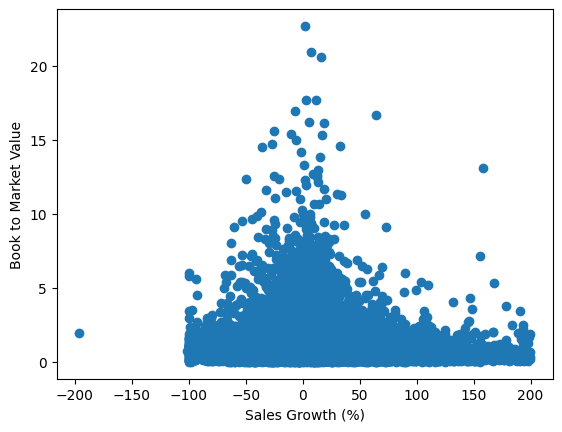

In [72]:
plt.scatter(df['sg'],df['beme'])
plt.xlabel("Sales Growth (%)")
plt.ylabel("Book to Market Value")
plt.show()

In [74]:
np.corrcoef(df['sg'],df['beme'])

array([[ 1.        , -0.15446722],
       [-0.15446722,  1.        ]])